<a href="https://colab.research.google.com/github/RiddhimanSarkar25/PneumoScan2.0/blob/main/gradcam_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


In [ ]:
import os
os.makedirs("models", exist_ok=True)


In [ ]:
# Install required packages
!pip install tensorflow opencv-python scikit-learn matplotlib pandas gradio pillow --break-system-packages


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch
import torch.nn as nn
import torchvision.models as models
class PneumoniaModel(nn.Module):
    def __init__(self, num_classes=2):
        super(PneumoniaModel, self).__init__()

        # Load pretrained ResNet50
        self.base_model = models.resnet50(pretrained=True)

        # Replace final classification layer
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PneumoniaModel(num_classes=2)
model = model.to(device)


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.utils.class_weight import compute_class_weight

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Using device: cuda


In [ ]:
model = model.to(device)


In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"ahana1864","key":"fd6dfc452061de11f76d998d63cfd21a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip chest-xray-pneumonia.zip


Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls


 chest_xray		   'kaggle (1).json'   kaggle.json   models
 chest-xray-pneumonia.zip  'kaggle (2).json'   labels.csv    sample_data


In [ ]:
import os
import pandas as pd

base_dir = "/content/chest_xray/train"

data = []

label_map = {
    "NORMAL": 0,
    "PNEUMONIA": 1
}


for label_name, label in label_map.items():
    folder_path = os.path.join(base_dir, label_name)

    for img in os.listdir(folder_path):
        if img.lower().endswith((".jpeg", ".jpg", ".png")):

            img_path = os.path.join(folder_path, img)
            data.append([img_path, label])

df = pd.DataFrame(data, columns=["image_path", "label"])

df.to_csv("labels.csv", index=False)

print("CSV created!")
print(df.head())


CSV created!
                                          image_path  label
0  /content/chest_xray/train/NORMAL/NORMAL2-IM-03...      0
1  /content/chest_xray/train/NORMAL/IM-0553-0001-...      0
2  /content/chest_xray/train/NORMAL/IM-0677-0001....      0
3  /content/chest_xray/train/NORMAL/IM-0555-0001-...      0
4  /content/chest_xray/train/NORMAL/NORMAL2-IM-12...      0


In [ ]:
print("\n📊 Class Distribution:")
print(df['label'].value_counts())



📊 Class Distribution:
label
1    3875
0    1341
Name: count, dtype: int64


In [ ]:
CSV_PATH = "/content/labels.csv"
df = pd.read_csv(CSV_PATH)


In [ ]:
CSV_PATH = "/content/labels.csv"   # the CSV you just created

IMG_SIZE = 224
BATCH_SIZE = 16      # safer for Colab
EPOCHS = 5           # prototype value
LEARNING_RATE = 1e-4


Dataset shape: (5216, 2)

First few rows:
                                          image_path  label
0  /content/chest_xray/train/NORMAL/NORMAL2-IM-03...      0
1  /content/chest_xray/train/NORMAL/IM-0553-0001-...      0
2  /content/chest_xray/train/NORMAL/IM-0677-0001....      0
3  /content/chest_xray/train/NORMAL/IM-0555-0001-...      0
4  /content/chest_xray/train/NORMAL/NORMAL2-IM-12...      0

Class Distribution:
label
1    3875
0    1341
Name: count, dtype: int64


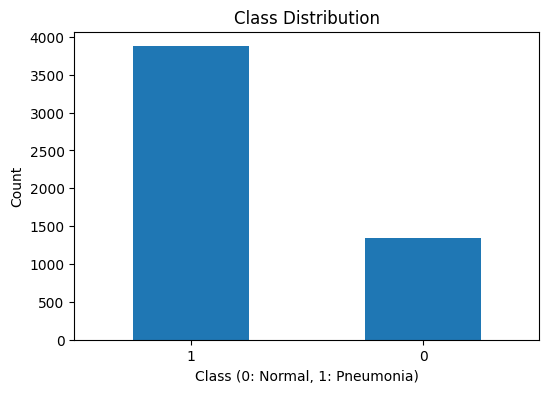

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(CSV_PATH)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nClass Distribution:")
print(df['label'].value_counts())

plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class (0: Normal, 1: Pneumonia)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/labels.csv")

print(df.head())


                                          image_path  label
0  /content/chest_xray/train/NORMAL/NORMAL2-IM-03...      0
1  /content/chest_xray/train/NORMAL/IM-0553-0001-...      0
2  /content/chest_xray/train/NORMAL/IM-0677-0001....      0
3  /content/chest_xray/train/NORMAL/IM-0555-0001-...      0
4  /content/chest_xray/train/NORMAL/NORMAL2-IM-12...      0


In [ ]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['label'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


Training samples: 3651
Validation samples: 782
Test samples: 783


In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([

    transforms.RandomRotation(10),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(
    p=0,
    scale=(0.02, 0.15),
    ratio=(0.3, 3.3),
    ),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)
    ),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.loc[idx, 'image_path']
        label = self.data.loc[idx, 'label']

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
train_dataset = ChestXrayDataset(train_df, transform=train_transform)
val_dataset   = ChestXrayDataset(val_df, transform=val_test_transform)
test_dataset  = ChestXrayDataset(test_df, transform=val_test_transform)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
print(len(train_dataset))
print(train_dataset[0])


3651
(tensor([[[-0.7137, -0.6794, -0.6965,  ..., -2.1179, -2.1179, -2.1179],
         [-0.7822, -0.8164, -0.7993,  ..., -2.1179, -2.1179, -2.1179],
         [-0.9534, -0.9534, -0.9705,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-0.6001, -0.5651, -0.5826,  ..., -2.0357, -2.0357, -2.0357],
         [-0.6702, -0.7052, -0.6877,  ..., -2.0357, -2.0357, -2.0357],
         [-0.8452, -0.8452, -0.8627,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-0.3753, -0.3404, -0.3578,  ..., -1.8044, -1.8044, -1.8044],
         [-0.4450, -0.4798, -0.4624,  .

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch_pytorch(dataloader):
    images, labels = next(iter(dataloader))

    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()

    class_names = {0: 'Normal', 1: 'Pneumonia'}

    for i in range(8):
        img = images[i].permute(1, 2, 0)  # [C,H,W] → [H,W,C]
        img = img.numpy()

        # Undo normalization for display
        img = (img - img.min()) / (img.max() - img.min())

        axes[i].imshow(img)
        axes[i].set_title(f"Class: {class_names[labels[i].item()]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


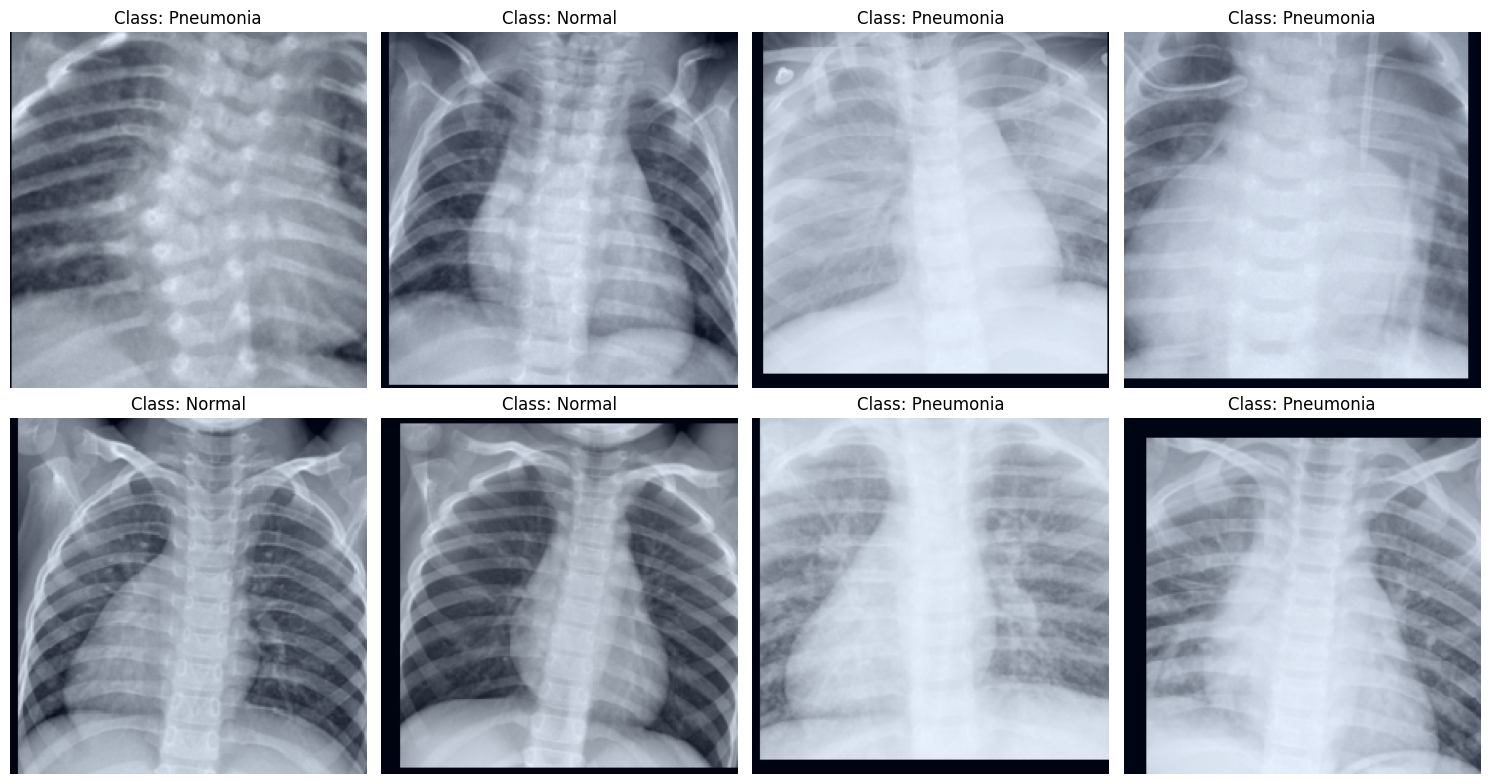

In [ ]:
show_batch_pytorch(train_loader)


In [ ]:
import torch.nn as nn
from torchvision import models

class PneumoniaModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        # Load pretrained ResNet50
        self.base_model = models.resnet50(pretrained=True)

        # Freeze backbone
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace classification head
        in_features = self.base_model.fc.in_features # This is typically 2048 for ResNet50
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Explicitly define the forward pass to ensure correct data flow
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)

        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)

        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1) # Ensure the feature map is flattened
        x = self.base_model.fc(x) # Pass through the custom classification head

        return x

model = PneumoniaModel(num_classes=2)
model = model.to(device)
print("✅ Model created and moved to device")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model created and moved to device


In [ ]:
# Cell removed: Model re-initialization is not needed and can cause issues.
# model = PneumoniaModel(num_classes=2)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

# Boost pneumonia recall
class_weights[1] *= 1.5

class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights.to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

print("Class weights:", class_weights)


Class weights: tensor([1.9441, 1.0097], device='cuda:0')


In [ ]:
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


In [ ]:
optimizer = torch.optim.Adam(
    model.parameters(),
   lr=LEARNING_RATE
)


In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move to device
        images = images.to(device)
        labels = labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    # For recall calculation
    tp, fp, tn, fn = 0, 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Calculate TP, FP, TN, FN for pneumonia class (label=1)
            tp += ((predicted == 1) & (labels == 1)).sum().item()
            fp += ((predicted == 1) & (labels == 0)).sum().item()
            tn += ((predicted == 0) & (labels == 0)).sum().item()
            fn += ((predicted == 0) & (labels == 1)).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_recall = tp / (tp + fn + 1e-8)
    val_precision = tp / (tp + fp + 1e-8)

    return val_loss, val_acc, val_recall, val_precision


In [ ]:
# model = model.to(device)

In [ ]:
EPOCHS = 8 # Adjust as needed
best_val_recall = 0.0
patience = 7
epochs_without_improvement = 0

os.makedirs("models", exist_ok=True)

# Track history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_recall': [],
    'val_precision': []
}

print("\n" + "="*60)
print("🚀 STARTING TRAINING")
print("="*60)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 40)

    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_recall, val_precision = validate(model, val_loader, criterion, device)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_recall'].append(val_recall)
    history['val_precision'].append(val_precision)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Val Recall: {val_recall:.4f} | Val Precision: {val_precision:.4f}")

    # Save best model based on recall
    if val_recall > best_val_recall:
        best_val_recall = val_recall
        torch.save(model.state_dict(), "models/best_model.pth")
        print(f"✅ Best model saved! (Recall: {val_recall:.4f})")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Early stopping
    if epochs_without_improvement >= patience:
        print(f"\n⚠️ Early stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("="*60)



🚀 STARTING TRAINING

Epoch 1/8
----------------------------------------
Train Loss: 0.2328 | Train Acc: 0.9102
Val Loss: 0.2372 | Val Acc: 0.8862
Val Recall: 0.8589 | Val Precision: 0.9862
✅ Best model saved! (Recall: 0.8589)

Epoch 2/8
----------------------------------------
Train Loss: 0.2221 | Train Acc: 0.9178
Val Loss: 0.1892 | Val Acc: 0.9143
Val Recall: 0.9002 | Val Precision: 0.9831
✅ Best model saved! (Recall: 0.9002)

Epoch 3/8
----------------------------------------
Train Loss: 0.2133 | Train Acc: 0.9203
Val Loss: 0.1667 | Val Acc: 0.9246
Val Recall: 0.9174 | Val Precision: 0.9798
✅ Best model saved! (Recall: 0.9174)

Epoch 4/8
----------------------------------------
Train Loss: 0.2099 | Train Acc: 0.9200
Val Loss: 0.1872 | Val Acc: 0.9143
Val Recall: 0.8898 | Val Precision: 0.9942

Epoch 5/8
----------------------------------------
Train Loss: 0.2074 | Train Acc: 0.9274
Val Loss: 0.1425 | Val Acc: 0.9348
Val Recall: 0.9312 | Val Precision: 0.9801
✅ Best model saved! (Re

In [ ]:
# Execute the cell that defines test_gradcam
%exec Mbn_3KqUcvBE

UsageError: Line magic function `%exec` not found.


In [ ]:
# Now, run the test_gradcam function with the updated definition
test_gradcam(best_model, test_df, device, num_samples=3)

NameError: name 'test_gradcam' is not defined

In [ ]:
# Execute the cell that defines get_gradcam_heatmap to update it in the kernel
# This ensures the changes made are active.
%exec NuOZ2LH7RXNn

UsageError: Line magic function `%exec` not found.


In [ ]:
# Execute the cell that defines test_gradcam to update it in the kernel
# This ensures the changes made are active.
%exec Mbn_3KqUcvBE

UsageError: Line magic function `%exec` not found.



🎨 GRAD-CAM VISUALIZATION

──────────────────────────────────────────────────────────────────────
📸 Image: person773_virus_1402.jpeg
🏷️  True label: PNEUMONIA
🔥 visualize_with_gradcam CALLED


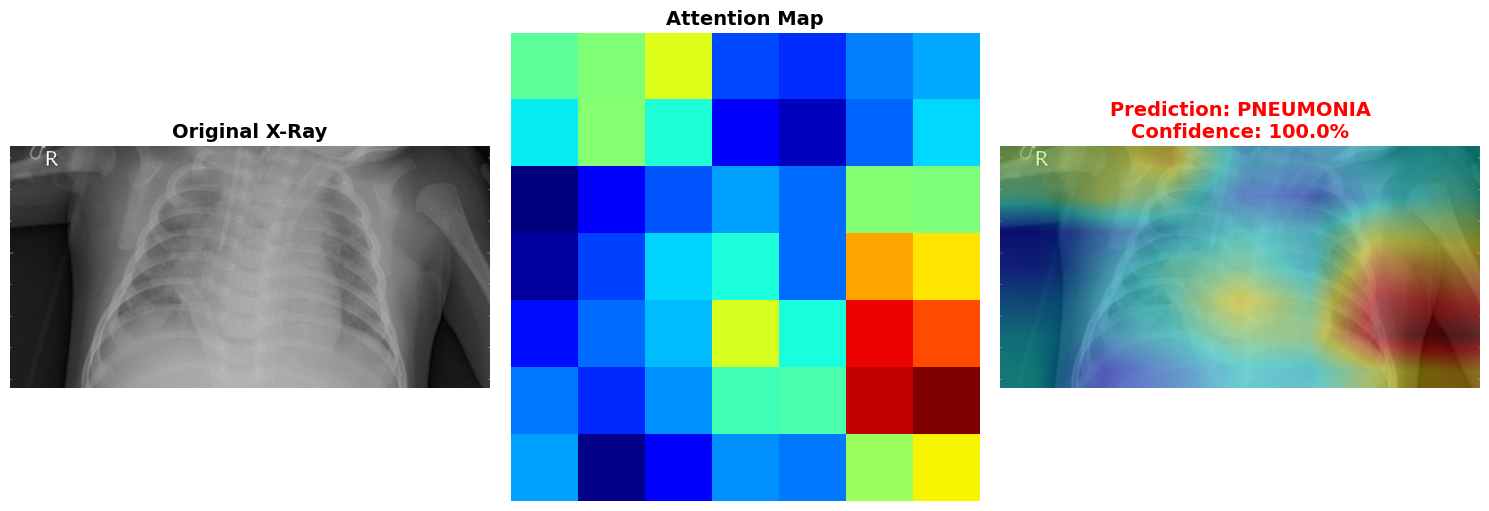

🤖 Predicted: PNEUMONIA (100.0%)
✅ Correct!

──────────────────────────────────────────────────────────────────────
📸 Image: person413_bacteria_1832.jpeg
🏷️  True label: PNEUMONIA
🔥 visualize_with_gradcam CALLED


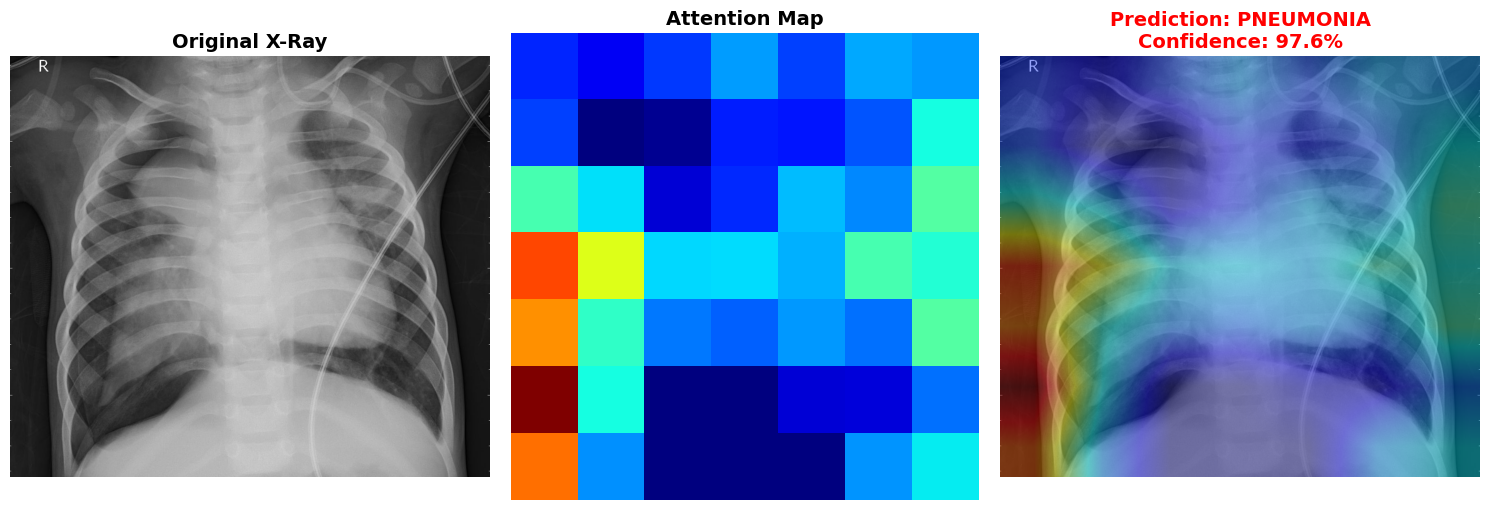

🤖 Predicted: PNEUMONIA (97.6%)
✅ Correct!

──────────────────────────────────────────────────────────────────────
📸 Image: person551_virus_1091.jpeg
🏷️  True label: PNEUMONIA
🔥 visualize_with_gradcam CALLED


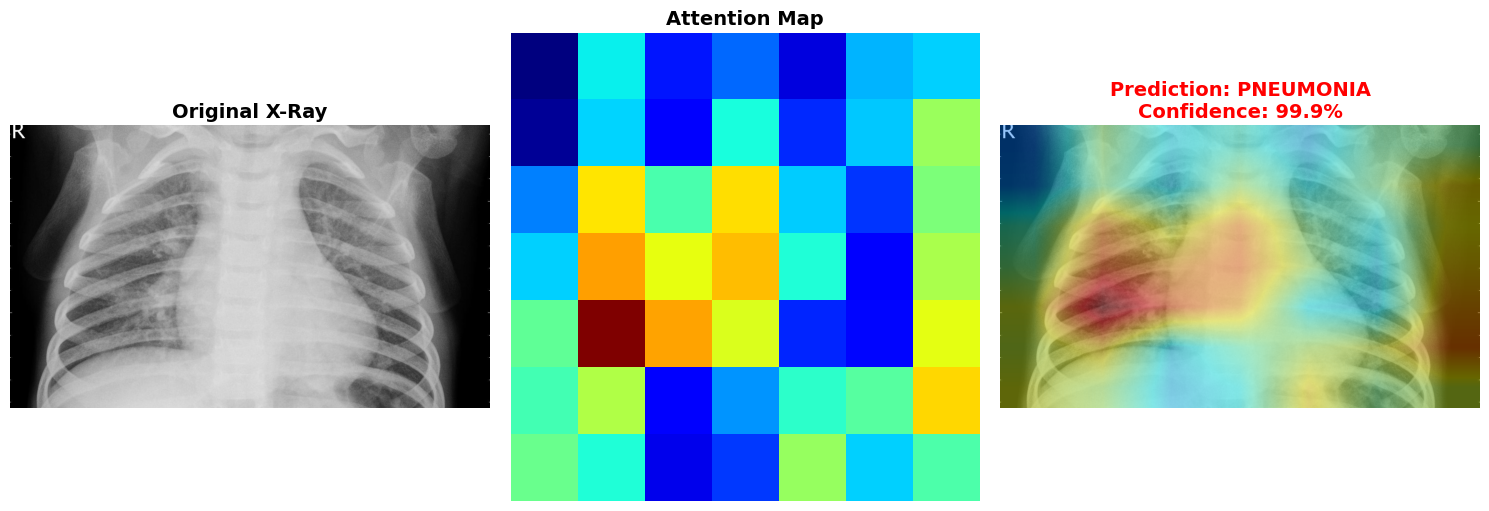

🤖 Predicted: PNEUMONIA (99.9%)
✅ Correct!

✅ GRAD-CAM COMPLETE!


In [ ]:
# Now, run the test_gradcam function with the updated definition
test_gradcam(best_model, test_df, device, num_samples=3)

In [ ]:
# Execute the cell that defines get_gradcam_heatmap to update it in the kernel
# This ensures the changes made are active.
%exec NuOZ2LH7RXNn

In [ ]:
# Execute the cell that defines test_gradcam to update it in the kernel
# This ensures the changes made are active.
%exec Mbn_3KqUcvBE

In [ ]:
# Now, run the test_gradcam function with the updated definition
test_gradcam(best_model, test_df, device, num_samples=3)

NameError: name 'test_gradcam' is not defined

/tmp/ipython-input-1971615937.py:38: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1971615937.py:39: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.savefig('models/training_history.png', dpi=150)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


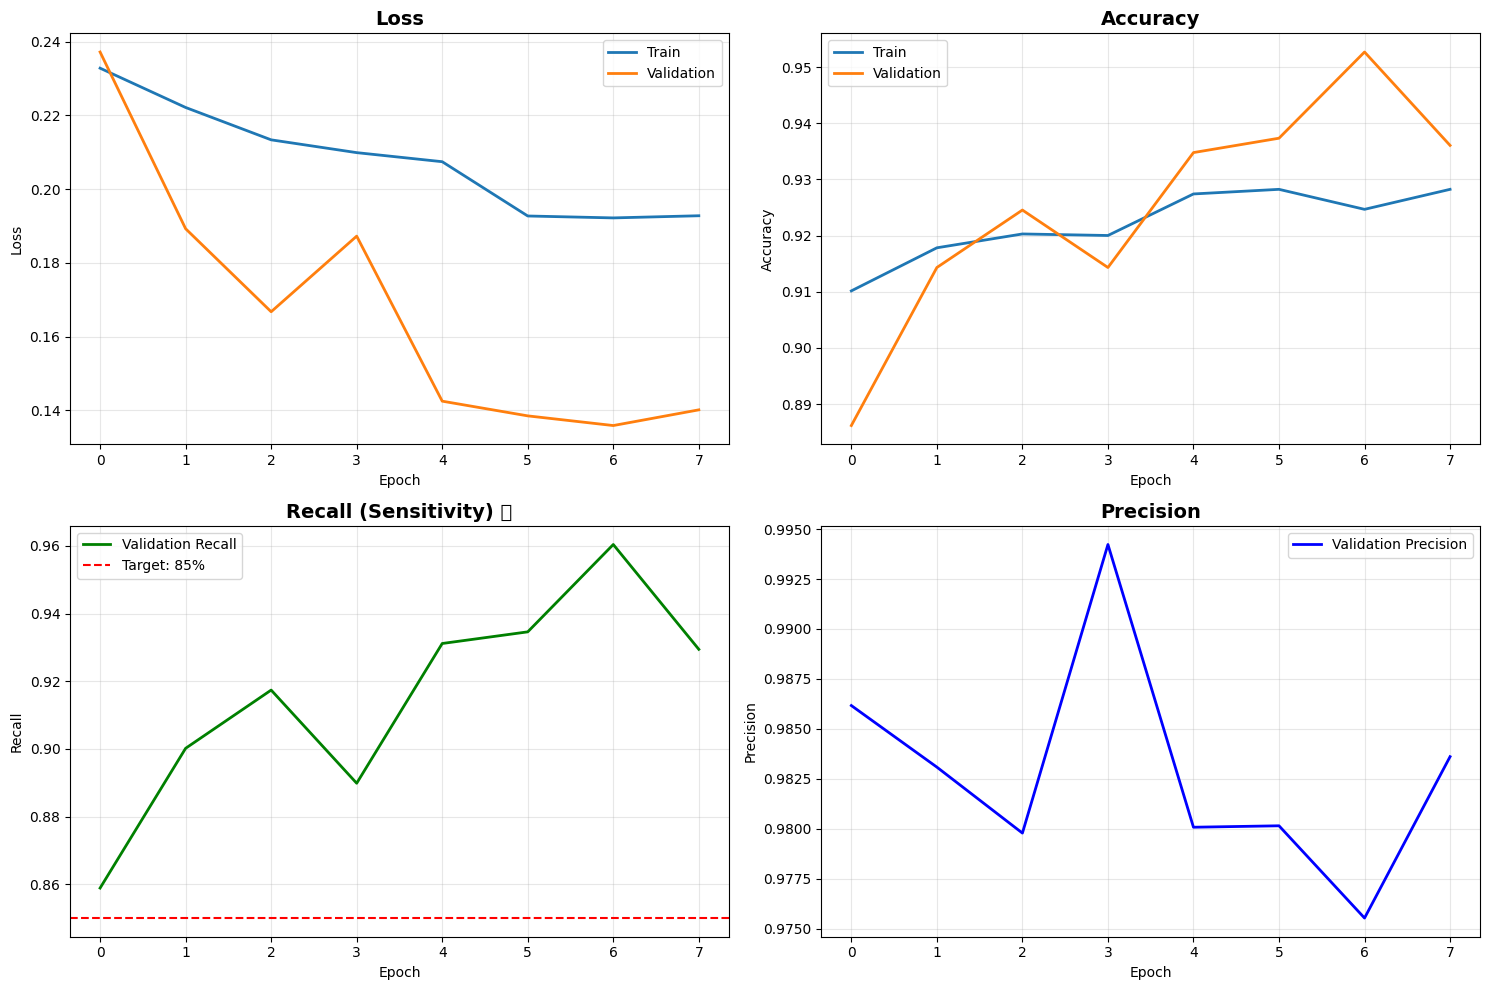

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Validation', linewidth=2)
axes[0, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Recall
axes[1, 0].plot(history['val_recall'], label='Validation Recall', linewidth=2, color='green')
axes[1, 0].set_title('Recall (Sensitivity) ⭐', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].axhline(y=0.85, color='r', linestyle='--', label='Target: 85%')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Precision
axes[1, 1].plot(history['val_precision'], label='Validation Precision', linewidth=2, color='blue')
axes[1, 1].set_title('Precision', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/training_history.png', dpi=150)
plt.show()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



📂 Best model loaded

📋 TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

      NORMAL     0.8873    0.9403    0.9130       201
   PNEUMONIA     0.9789    0.9588    0.9688       582

    accuracy                         0.9540       783
   macro avg     0.9331    0.9495    0.9409       783
weighted avg     0.9554    0.9540    0.9544       783



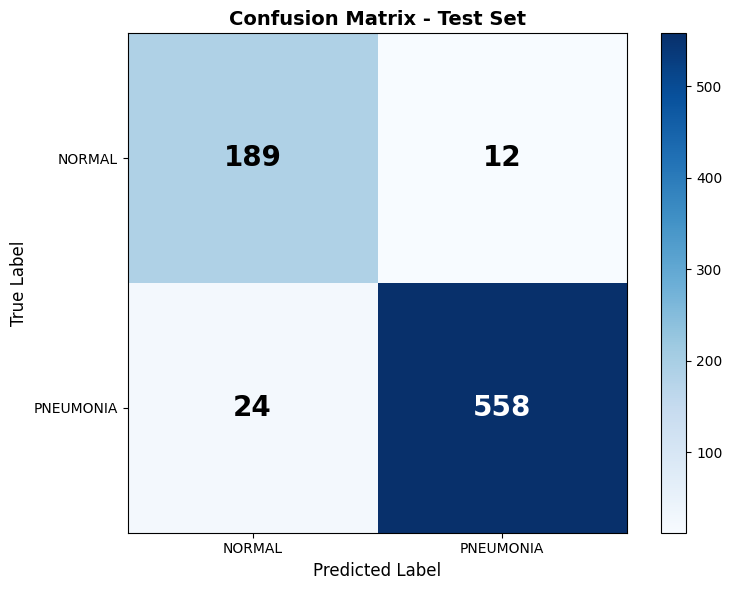


📊 Confusion Matrix Breakdown:
   True Negatives (TN):  189 - Correctly identified NORMAL
   False Positives (FP): 12 - NORMAL incorrectly labeled as PNEUMONIA
   False Negatives (FN): 24 - PNEUMONIA incorrectly labeled as NORMAL ❌
   True Positives (TP):  558 - Correctly identified PNEUMONIA ✅

⚠️ Miss rate: 24/582 = 4.1% of pneumonia cases missed

✅ Training and evaluation complete!
📁 Saved files:
   - models/best_model.pth
   - models/training_history.png
   - models/confusion_matrix.png


In [ ]:
# Load best model
best_model = PneumoniaModel(num_classes=2)
best_model.load_state_dict(torch.load("models/best_model.pth"))
best_model = best_model.to(device)
best_model.eval()

print("\n📂 Best model loaded")

# Get predictions on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification report
print("\n" + "="*60)
print("📋 TEST SET CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_labels, all_preds,
                          target_names=['NORMAL', 'PNEUMONIA'],
                          digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['NORMAL', 'PNEUMONIA'])
plt.yticks(tick_marks, ['NORMAL', 'PNEUMONIA'])

# Add text annotations
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=20, fontweight='bold')

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('models/confusion_matrix.png', dpi=150)
plt.show()

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Confusion Matrix Breakdown:")
print(f"   True Negatives (TN):  {tn:,} - Correctly identified NORMAL")
print(f"   False Positives (FP): {fp:,} - NORMAL incorrectly labeled as PNEUMONIA")
print(f"   False Negatives (FN): {fn:,} - PNEUMONIA incorrectly labeled as NORMAL ❌")
print(f"   True Positives (TP):  {tp:,} - Correctly identified PNEUMONIA ✅")
print(f"\n⚠️ Miss rate: {fn}/{fn+tp} = {fn/(fn+tp)*100:.1f}% of pneumonia cases missed")

print("\n✅ Training and evaluation complete!")
print("📁 Saved files:")
print("   - models/best_model.pth")
print("   - models/training_history.png")
print("   - models/confusion_matrix.png")




In [ ]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms


In [ ]:
def auto_crop_xray(img_path, crop_percentage=0.1):
    """
    Automatically crop X-ray to focus on lung region

    Args:
        img_path: Path to image
        crop_percentage: How much to crop from edges (0.1 = 10%)

    Returns:
        cropped_img: Cropped PIL Image
        crop_info: Dictionary with crop coordinates
    """
    # Load image
    img = Image.open(img_path).convert('RGB')
    width, height = img.size

    # Calculate crop box (remove edges)
    left = int(width * crop_percentage)
    top = int(height * crop_percentage)
    right = int(width * (1 - crop_percentage))
    bottom = int(height * (1 - crop_percentage))

    # Crop image
    cropped = img.crop((left, top, right, bottom))

    crop_info = {
        'original_size': (width, height),
        'crop_box': (left, top, right, bottom),
        'cropped_size': cropped.size
    }

    return cropped, crop_info

In [ ]:
def smart_crop_xray(img_path, target_size=(224, 224)):
    """
    Smart cropping - removes black borders and focuses on lung area

    Args:
        img_path: Path to X-ray image
        target_size: Final size after cropping

    Returns:
        cropped_img: Cropped and resized image
        original_img: Original image for comparison
    """
    # Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to grayscale for finding content
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold to find non-black regions
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get bounding box of largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Add small padding
        padding = 10
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(img.shape[1] - x, w + 2*padding)
        h = min(img.shape[0] - y, h + 2*padding)

        # Crop
        cropped = img_rgb[y:y+h, x:x+w]
    else:
        # If no contours found, use original
        cropped = img_rgb

    # Convert to PIL for consistency
    cropped_pil = Image.fromarray(cropped)
    original_pil = Image.fromarray(img_rgb)

    return cropped_pil, original_pil


In [ ]:
def get_gradcam_heatmap(model, img_tensor, target_class=None):
    model.eval()

    # ✅ KEY FIX: Don't detach, keep gradients flowing
    img_tensor = img_tensor.clone()
    img_tensor.requires_grad_(True)

    # Forward pass - manually through each layer
    x = img_tensor

    x = model.base_model.conv1(x)
    x = model.base_model.bn1(x)
    x = model.base_model.relu(x)
    x = model.base_model.maxpool(x)

    x = model.base_model.layer1(x)
    x = model.base_model.layer2(x)
    x = model.base_model.layer3(x)
    x = model.base_model.layer4(x)

    # ✅ CRITICAL: Save activations AND enable gradients on them
    activations = x
    activations.retain_grad()  # ✅ This ensures gradients are kept!

    # Complete forward pass
    x = model.base_model.avgpool(activations)
    x = torch.flatten(x, 1)
    output = model.base_model.fc(x)

    # Get prediction
    probs = F.softmax(output, dim=1)
    if target_class is None:
        target_class = torch.argmax(probs, dim=1).item()
    confidence = probs[0, target_class].item()

    # ✅ Backward pass
    model.zero_grad()

    # Select only the target class score
    class_score = output[0, target_class]

    # Backward
    class_score.backward()

    # ✅ NOW get gradients
    gradients = activations.grad

    # ✅ Check if gradients exist
    if gradients is None:
        print("⚠️ Warning: Gradients are None! Using zeros.")
        # Fallback: create zero heatmap
        activations_np = activations.detach().cpu().numpy()[0]
        heatmap = np.zeros(activations_np.shape[1:], dtype=np.float32)
        return heatmap, target_class, confidence

    # Convert to numpy
    gradients_np = gradients.cpu().numpy()[0]  # [C, H, W]
    activations_np = activations.detach().cpu().numpy()[0]  # [C, H, W]

    # Compute weights (global average pooling)
    weights = np.mean(gradients_np, axis=(1, 2))  # [C]

    # Weighted combination
    heatmap = np.zeros(activations_np.shape[1:], dtype=np.float32)  # [H, W]

    for i in range(len(weights)):
        heatmap += weights[i] * activations_np[i]

    # ReLU
    heatmap = np.maximum(heatmap, 0)

    # Normalize
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()

    return heatmap, target_class, confidence


In [ ]:

def get_gradcam_heatmap(model, img_tensor, target_class=None):
    """Generate Grad-CAM heatmap (same as before)"""
    model.eval()

    img_tensor = img_tensor.clone().detach()
    img_tensor.requires_grad = True

    # Forward pass
    x = img_tensor
    x = model.base_model.conv1(x)
    x = model.base_model.bn1(x)
    x = model.base_model.relu(x)
    x = model.base_model.maxpool(x)

    x = model.base_model.layer1(x)
    x = model.base_model.layer2(x)
    x = model.base_model.layer3(x)
    x = model.base_model.layer4(x)

    target_activations = x

    x = model.base_model.avgpool(x)
    activations.retain_grad()
    x = torch.flatten(x, 1)
    output = model.base_model.fc(x)

    # Get prediction
    probs = F.softmax(output, dim=1)
    if target_class is None:
        target_class = torch.argmax(probs, dim=1).item()
    confidence = probs[0, target_class].item()

    # Backward pass
    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward(retain_graph=False)

    # Get gradients
    gradients = target_activations.grad
    gradients_np = gradients.detach().cpu().numpy()[0]
    activations_np = target_activations.detach().cpu().numpy()[0]

    # Compute CAM
    weights = np.mean(gradients_np, axis=(1, 2))
    cam = np.zeros(activations_np.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * activations_np[i, :, :]

    cam = np.maximum(cam, 0)
    if cam.max() != 0:
        cam = cam / cam.max()

    return cam, target_class, confidence



In [ ]:
def auto_crop_xray(img_path, crop_percentage=0.7):
    """Simple edge cropping"""
    img = Image.open(img_path).convert('RGB')
    width, height = img.size

    left = int(width * crop_percentage)
    top = int(height * crop_percentage)
    right = int(width * (1 - crop_percentage))
    bottom = int(height * (1 - crop_percentage))

    cropped = img.crop((left, top, right, bottom))

    return cropped, img

In [ ]:
def visualize_with_gradcam(img_path, model, device, use_crop=True):
    """
    Visualize with Grad-CAM

    Args:
        img_path: Path to X-ray
        model: Trained model
        device: torch device
        use_crop: Whether to crop (True/False)

    Returns:
        pred_class, confidence
    """
    # Preprocessing
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load and optionally crop
    if use_crop:
        img_pil, original_pil = auto_crop_xray(img_path, crop_percentage=0.1)
        print(f"   📐 Cropping applied (10% edges removed)")
    else:
        img_pil = Image.open(img_path).convert('RGB')
        original_pil = img_pil
        print(f"   📐 No cropping")

    # Preprocess
    img_tensor = preprocess(img_pil).unsqueeze(0).to(device)

    # Generate Grad-CAM
    heatmap, pred_class, confidence = get_gradcam_heatmap(model, img_tensor)

    # Convert for visualization
    img_for_overlay = np.array(img_pil)
    original_img = np.array(original_pil)

    # Resize heatmap
    heatmap_resized = cv2.resize(heatmap, (img_for_overlay.shape[1], img_for_overlay.shape[0]))

    # Colormap
    heatmap_colored = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Overlay
    superimposed = cv2.addWeighted(img_for_overlay, 0.6, heatmap_colored, 0.4, 0)

    # Plot
    if use_crop:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        axes[0].imshow(original_img)
        axes[0].set_title('Original', fontsize=12, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(img_for_overlay)
        axes[1].set_title('Cropped', fontsize=12, fontweight='bold')
        axes[1].axis('off')

        axes[2].imshow(heatmap, cmap='jet')
        axes[2].set_title('Grad-CAM', fontsize=12, fontweight='bold')
        axes[2].axis('off')

        class_names = ['NORMAL', 'PNEUMONIA']
        color = 'red' if pred_class == 1 else 'green'
        axes[3].imshow(superimposed)
        axes[3].set_title(f'{class_names[pred_class]}\n{confidence:.1%}',
                         fontsize=12, fontweight='bold', color=color)
        axes[3].axis('off')
    else:
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))

        axes[0].imshow(original_img)
        axes[0].set_title('Original', fontsize=12, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(heatmap, cmap='jet')
        axes[1].set_title('Grad-CAM', fontsize=12, fontweight='bold')
        axes[1].axis('off')

        class_names = ['NORMAL', 'PNEUMONIA']
        color = 'red' if pred_class == 1 else 'green'
        axes[2].imshow(superimposed)
        axes[2].set_title(f'{class_names[pred_class]}\n{confidence:.1%}',
                         fontsize=12, fontweight='bold', color=color)
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return pred_class, confidence




🎨 GRAD-CAM WITH CROPPING

──────────────────────────────────────────────────────────────────────
📸 person16_bacteria_55.jpeg
🏷️  True: PNEUMONIA
   📐 Cropping applied (10% edges removed)


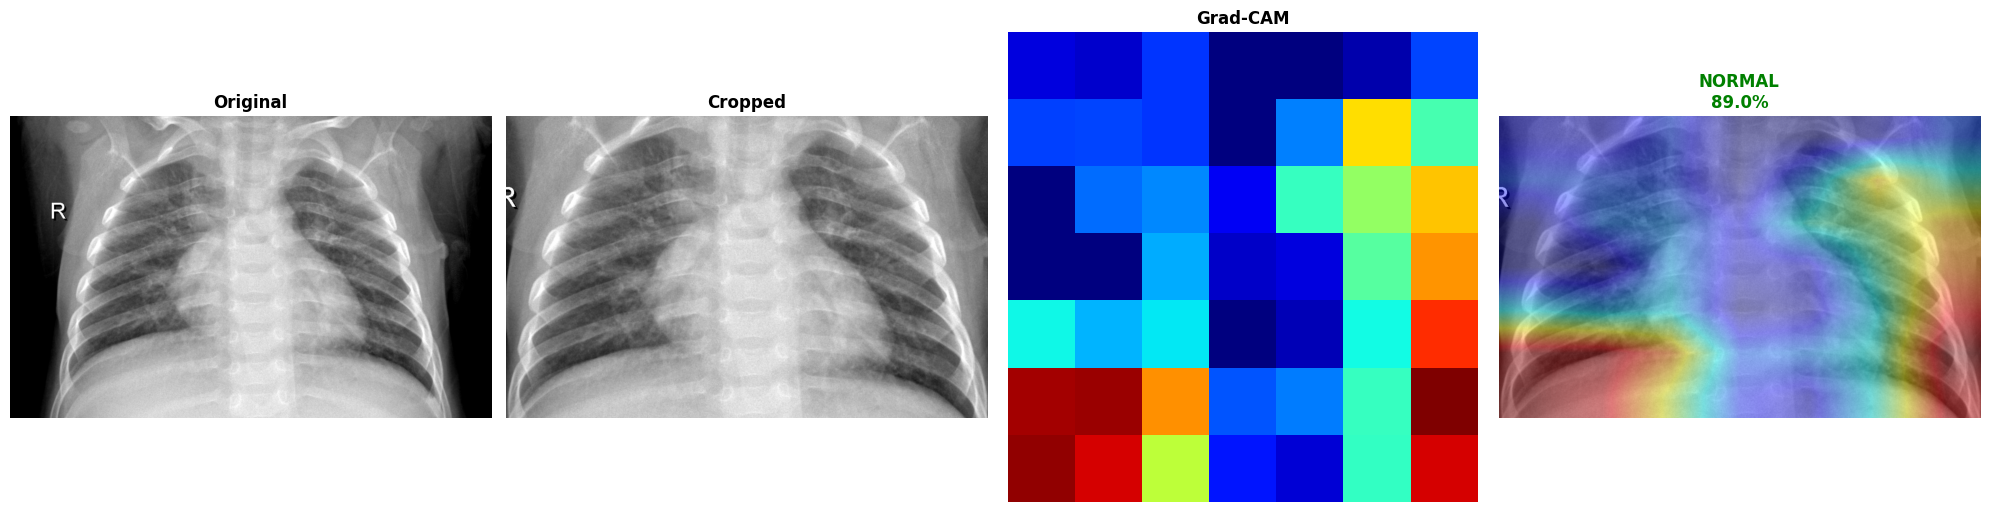

🤖 Pred: NORMAL (89.0%)
❌

──────────────────────────────────────────────────────────────────────
📸 NORMAL2-IM-0596-0001.jpeg
🏷️  True: NORMAL
   📐 Cropping applied (10% edges removed)


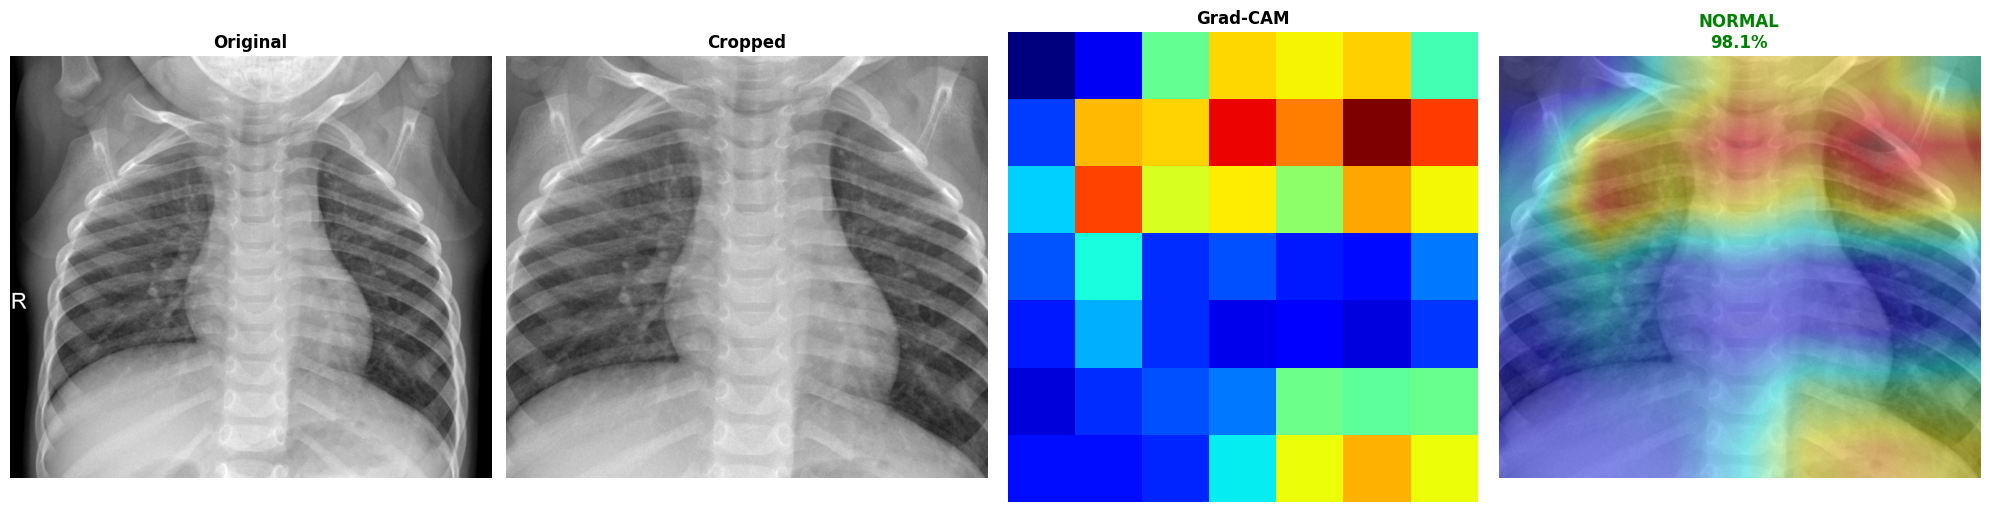

🤖 Pred: NORMAL (98.1%)
✅

──────────────────────────────────────────────────────────────────────
📸 person1343_bacteria_3417.jpeg
🏷️  True: PNEUMONIA
   📐 Cropping applied (10% edges removed)


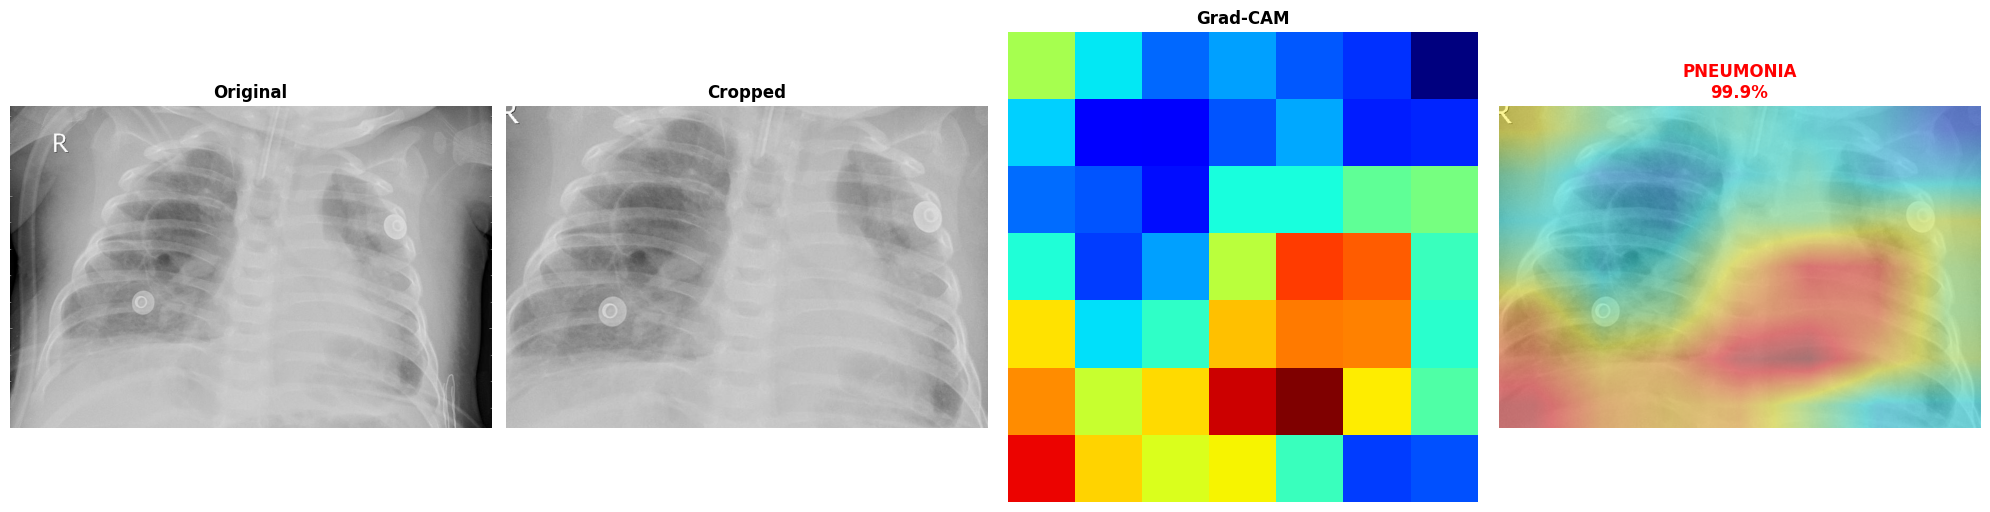

🤖 Pred: PNEUMONIA (99.9%)
✅

✅ DONE!


In [ ]:

def test_gradcam(model, test_df, device, num_samples=3, use_crop=True):
    """Test Grad-CAM on samples"""
    print("\n" + "="*70)
    print(f"🎨 GRAD-CAM {'WITH CROPPING' if use_crop else 'WITHOUT CROPPING'}")
    print("="*70)

    samples = test_df.sample(min(num_samples, len(test_df)))

    for idx, row in samples.iterrows():
        img_path = row['image_path']
        true_label = row['label']

        print(f"\n{'─'*70}")
        print(f"📸 {img_path.split('/')[-1]}")
        print(f"🏷️  True: {['NORMAL', 'PNEUMONIA'][true_label]}")

        try:
            pred, conf = visualize_with_gradcam(img_path, model, device, use_crop=use_crop)
            print(f"🤖 Pred: {['NORMAL', 'PNEUMONIA'][pred]} ({conf:.1%})")
            print("✅" if pred == true_label else "❌")
        except Exception as e:
            print(f"❌ Error: {e}")
            import traceback
            traceback.print_exc()

    print("\n" + "="*70)
    print("✅ DONE!")
    print("="*70)


# ============================================================================
# RUN THIS
# ============================================================================

# Test with cropping
test_gradcam(best_model, test_df, device, num_samples=3, use_crop=True)

# Or without cropping
# test_gradcam(best_model, test_df, device, num_samples=3, use_crop=False)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving person1015_virus_1701.jpeg to person1015_virus_1701 (1).jpeg


   📐 Cropping applied (10% edges removed)


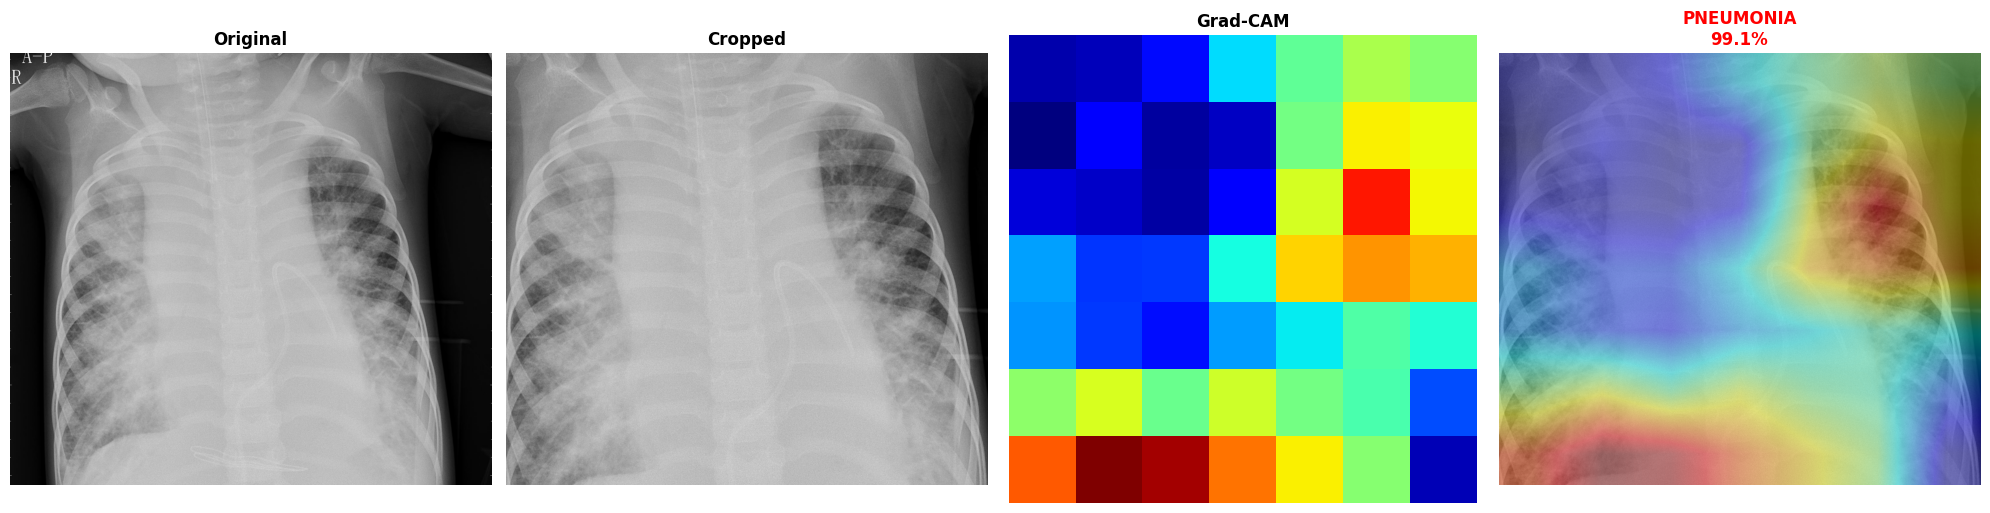

Predicted: PNEUMONIA (99.1%)


In [ ]:
img_path = list(uploaded.keys())[0]
img_path = f"/content/{img_path}"

pred, conf = visualize_with_gradcam(img_path, best_model, device)
print(f"Predicted: {['NORMAL', 'PNEUMONIA'][pred]} ({conf:.1%})")


In [ ]:
if __name__ == "__main__":
    """
    Just call this function at the end of your training script:

    test_gradcam(best_model, test_df, device, num_samples=4)
    """

    # Example usage (uncomment to use):
    # test_gradcam(best_model, test_df, device, num_samples=4)
    pass



🎨 GRAD-CAM WITH CROPPING

──────────────────────────────────────────────────────────────────────
📸 person323_virus_656.jpeg
🏷️  True: PNEUMONIA
   📐 Cropping applied (10% edges removed)


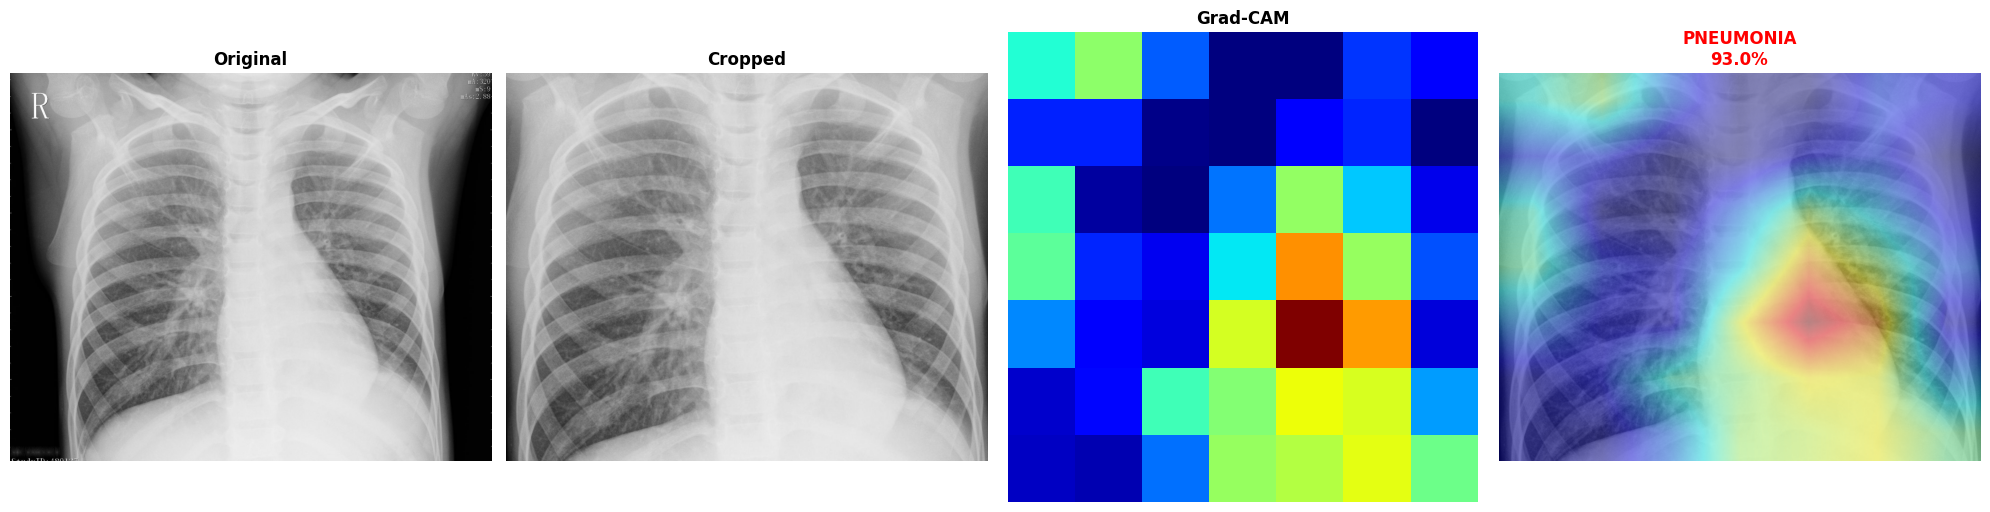

🤖 Pred: PNEUMONIA (93.0%)
✅

──────────────────────────────────────────────────────────────────────
📸 person1411_bacteria_3601.jpeg
🏷️  True: PNEUMONIA
   📐 Cropping applied (10% edges removed)


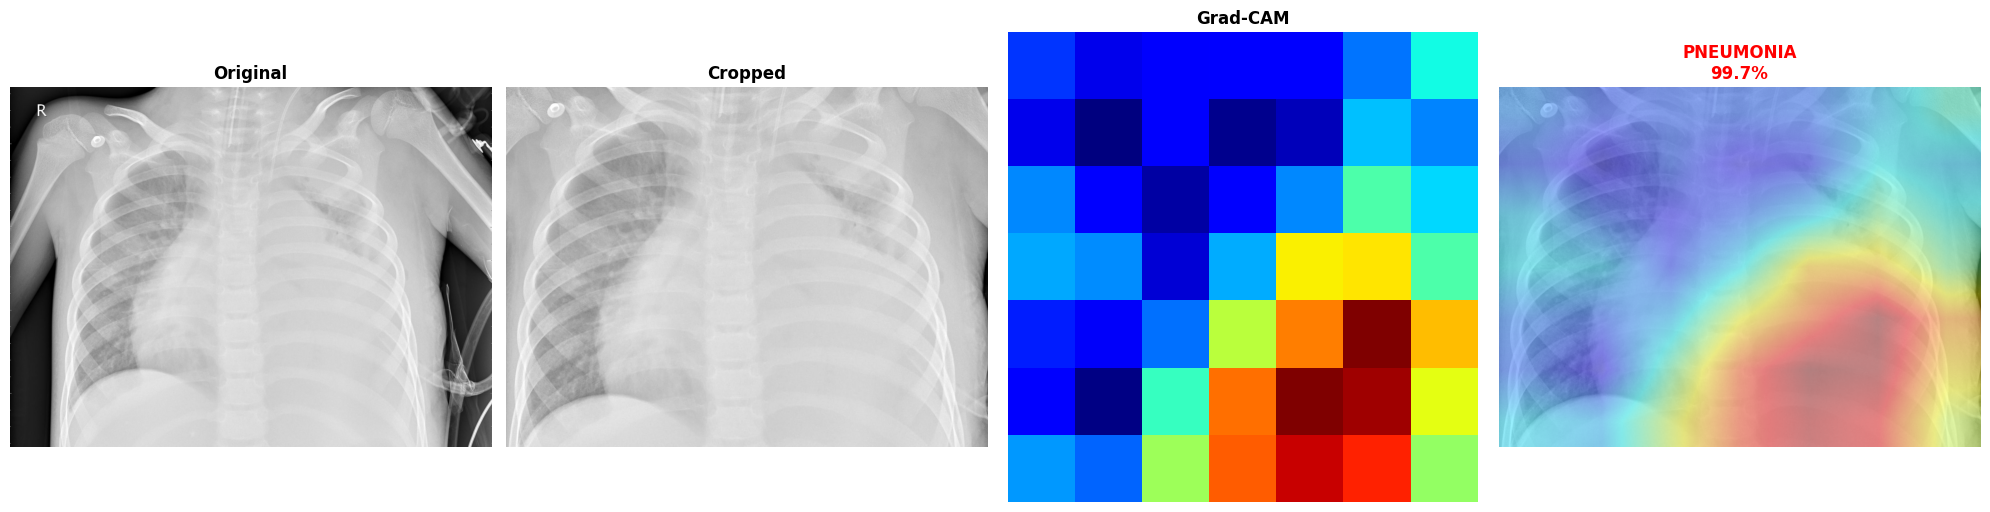

🤖 Pred: PNEUMONIA (99.7%)
✅

──────────────────────────────────────────────────────────────────────
📸 person773_virus_1402.jpeg
🏷️  True: PNEUMONIA
   📐 Cropping applied (10% edges removed)


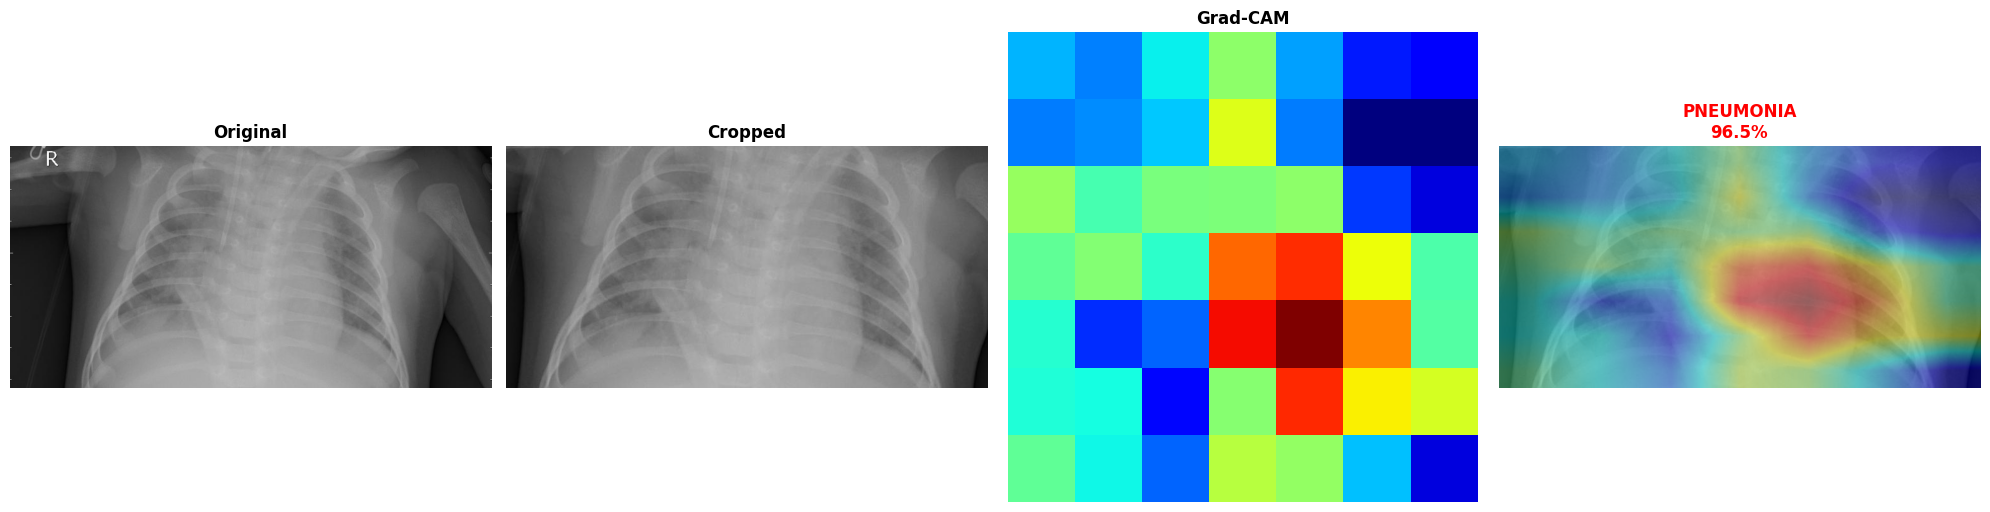

🤖 Pred: PNEUMONIA (96.5%)
✅

✅ DONE!


In [ ]:
# Now, run the test_gradcam function with the updated definition
test_gradcam(best_model, test_df, device, num_samples=3)

In [ ]:
best_model = PneumoniaModel(num_classes=2)
best_model.load_state_dict(torch.load("models/best_model.pth"))
best_model = best_model.to(device)
best_model.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PneumoniaModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
